In [1]:
import matplotlib.pyplot as plt

from turtle import forward
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

from torch.utils.data import Dataset, DataLoader


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
os.getcwd()



'/home/not7/src/Vladimir-Ershov.github.io/projects/MLRecap/torch'

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
NVIDIA GeForce RTX 3060
Using device: cuda


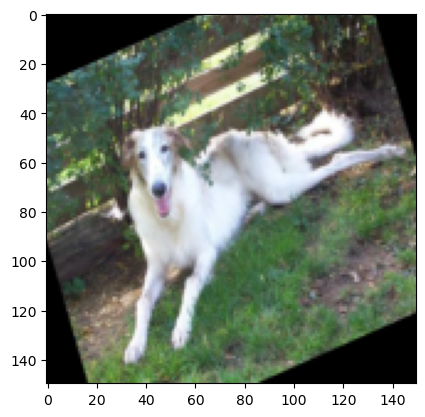

In [5]:
data_path = "../data/dogy/"
sample = '../data/dogy/train/borzoi/borzoi_19.jpg'

img = Image.open(sample)
img.size

preproc = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((150, 150)),    
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.3]), # x.mean(), x.std() (tensor(0.5055), tensor(0.2883))
])

img2 = preproc(img)
# img2
def imshow(img):
    img = img * 0.3 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# plt.imshow(np.transpose(img2, (1, 2, 0)))
# plt.show()
imshow(img2)

In [6]:
from random import shuffle
import torchvision
from torch.utils.data import DataLoader, random_split

selected_breeds = ['affenpinscher', 'akita', 'corgi']


batch_size =4
train_data = torchvision.datasets.ImageFolder(root=data_path + 'train/', transform=preproc)
test_data = torchvision.datasets.ImageFolder(root=data_path + 'test/', transform=preproc)

all_classes = train_data.classes 
selected_indices = [all_classes.index(b) for b in selected_breeds]

from torch.utils.data import Subset

def filter_by_breeds(dataset, selected_indices):
    filtered_idx = [i for i, (_, label) in enumerate(dataset.samples) if label in selected_indices]
    return Subset(dataset, filtered_idx)

train_data = filter_by_breeds(train_data, selected_indices)
test_data = filter_by_breeds(test_data, selected_indices)

breed_to_new_idx = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_indices)}

class RemappedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, breed_to_new_idx):
        self.subset = subset
        self.breed_to_new_idx = breed_to_new_idx
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        y = self.breed_to_new_idx[y]
        return x, y
    def __len__(self):
        return len(self.subset)

train_data = RemappedSubset(train_data, breed_to_new_idx)
test_data = RemappedSubset(test_data, breed_to_new_idx)




len_test_data = len(test_data)
len_train_data = len(train_data)

print(f"{len_train_data}/{len_test_data}   split = {len_test_data/(len_test_data + len_train_data)}")

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

# %%
available_breeds = ['affenpinscher', 'african', 'airedale', 'akita', 'appenzeller', 'australian', 'basenji', 'beagle', 'bluetick', 'borzoi', 'bouvier', 'boxer', 'brabancon', 'briard', 'buhund', 'bulldog', 'bullterrier', 'cattledog', 'chihuahua', 'chow', 'clumber', 'cockapoo', 'collie', 'coonhound', 'corgi', 'cotondetulear', 'dachshund', 'dalmatian', 'dane', 'deerhound', 'dhole', 'dingo', 'doberman', 'elkhound', 'entlebucher', 'eskimo', 'finnish', 'frise', 'germanshepherd', 'greyhound', 'groenendael', 'havanese', 'hound', 'husky', 'keeshond', 'kelpie', 'komondor', 'kuvasz', 'labradoodle', 'labrador', 'leonberg', 'lhasa', 'malamute', 'malinois', 'maltese', 'mastiff', 'mexicanhairless', 'mix', 'mountain', 'newfoundland', 'otterhound', 'ovcharka', 'papillon', 'pekinese', 'pembroke', 'pinscher', 'pitbull', 'pointer', 'pomeranian', 'poodle', 'pug', 'puggle', 'pyrenees', 'redbone', 'retriever', 'ridgeback', 'rottweiler', 'saluki', 'samoyed', 'schipperke', 'schnauzer', 'setter', 'sheepdog', 'shiba', 'shihtzu', 'spaniel', 'springer', 'stbernard', 'terrier', 'tervuren', 'vizsla', 'waterdog', 'weimaraner', 'whippet', 'wolfhound']
available_breeds = selected_breeds
NUM_CLASSES = len(available_breeds)

# TODO: set up model class
class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self, NUM_CLASSES, input_shape=(3,150,150)) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        dummy = torch.zeros(1, *input_shape)
        with torch.no_grad():
            n_features = self.features(dummy).numel()

        self.classifier = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# input = torch.rand(1, 1, 50, 50) # BS, C, H, W
model = ImageMulticlassClassificationNet(NUM_CLASSES)
model.to(device)

total_params = 0
for name, param in model.named_parameters():
    numel = param.numel()
    print(f"{name}: {param.shape} | {numel} params")
    total_params += numel

print(f"\nTotal parameters: {total_params}")


300/60   split = 0.16666666666666666
features.0.weight: torch.Size([6, 3, 3, 3]) | 162 params
features.0.bias: torch.Size([6]) | 6 params
features.3.weight: torch.Size([16, 6, 3, 3]) | 864 params
features.3.bias: torch.Size([16]) | 16 params
classifier.0.weight: torch.Size([512, 20736]) | 10616832 params
classifier.0.bias: torch.Size([512]) | 512 params
classifier.2.weight: torch.Size([256, 512]) | 131072 params
classifier.2.bias: torch.Size([256]) | 256 params
classifier.4.weight: torch.Size([3, 256]) | 768 params
classifier.4.bias: torch.Size([3]) | 3 params

Total parameters: 10750491


In [7]:
from torchviz import make_dot
import torch

x = torch.randn(1, 3, 150, 150).to(device)
y = model(x)

dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("network_architecture", format="png")

'network_architecture.png'

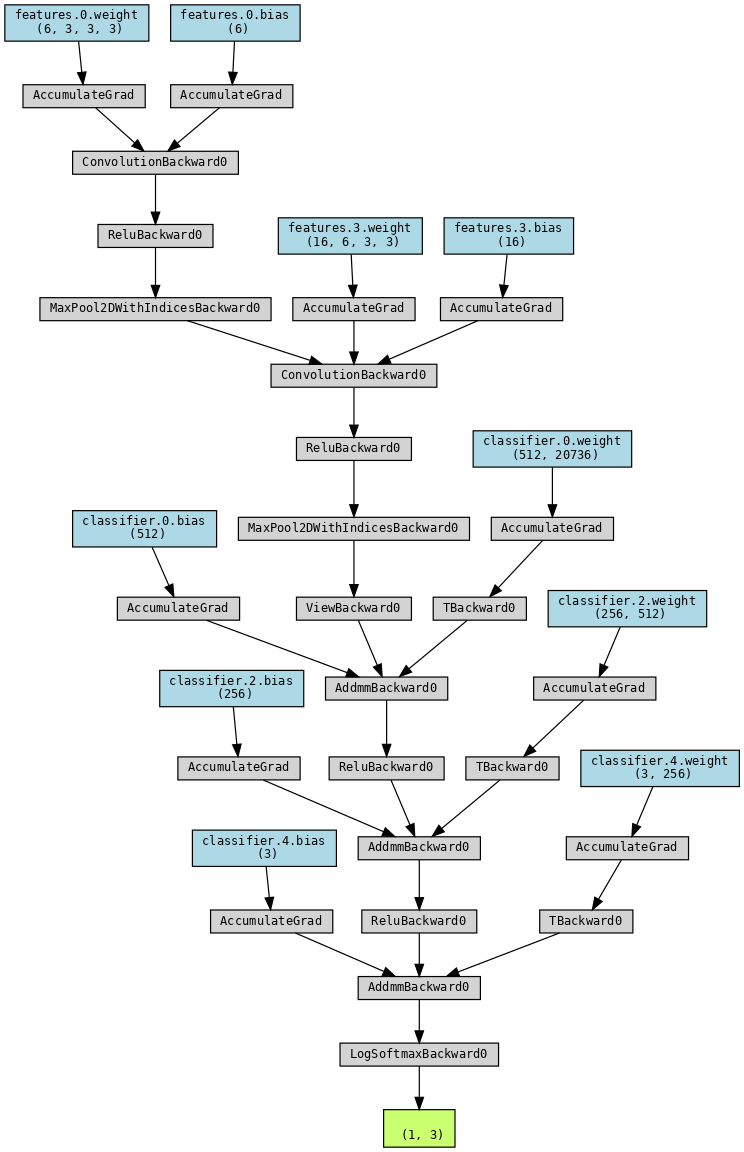

In [8]:
from IPython.display import Image, display
display(Image("network_architecture.png"))


In [12]:
from torchinfo import summary
summary(model, input_size=(1, 3, 150, 150), col_names=("kernel_size","output_size","num_params"), depth=4)

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
ImageMulticlassClassificationNet         --                        [1, 3]                    --
├─Sequential: 1-1                        --                        [1, 16, 36, 36]           --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 6, 148, 148]          168
│    └─ReLU: 2-2                         --                        [1, 6, 148, 148]          --
│    └─MaxPool2d: 2-3                    2                         [1, 6, 74, 74]            --
│    └─Conv2d: 2-4                       [3, 3]                    [1, 16, 72, 72]           880
│    └─ReLU: 2-5                         --                        [1, 16, 72, 72]           --
│    └─MaxPool2d: 2-6                    2                         [1, 16, 36, 36]           --
├─Sequential: 1-2                        --                        [1, 3]                    --
│    └─Linear: 2-7               

In [105]:
import torchvision.models as models
import torch.nn as nn

class ImageMulticlassClassificationNet2(nn.Module):
    def __init__(self, NUM_CLASSES):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        # Replace final classifier layer for 96 classes
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, NUM_CLASSES)
        self.classifier = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
model2 = ImageMulticlassClassificationNet2(NUM_CLASSES)
model2.to(device)


/home/not7/src/Vladimir-Ershov.github.io/projects/MLRecap/.pixi/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/not7/src/Vladimir-Ershov.github.io/projects/MLRecap/.pixi/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/not7/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.5MB/s]


ImageMulticlassClassificationNet2(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=

Epoch 0/10, Loss: 1.0526
Epoch 0/10, Loss: 1.2321
Epoch 0/10, Loss: 1.1437
Epoch 0/10, Loss: 1.0770
Epoch 0/10, Loss: 1.1133
Epoch 0/10, Loss: 1.0191
Epoch 0/10, Loss: 1.1190
Epoch 0/10, Loss: 1.1518
Epoch 0/10, Loss: 1.0478
Epoch 0/10, Loss: 1.0269
Epoch 0/10, Loss: 1.0500
Epoch 0/10, Loss: 0.9933
Epoch 0/10, Loss: 1.0296
Epoch 0/10, Loss: 0.9733
Epoch 0/10, Loss: 0.9544
Epoch 0/10, Loss: 1.0131
Epoch 0/10, Loss: 0.9522
Epoch 0/10, Loss: 1.0434
Epoch 0/10, Loss: 0.7250
Epoch 0/10, Loss: 1.1640
Epoch 0/10, Loss: 1.0722
Epoch 0/10, Loss: 1.0741
Epoch 0/10, Loss: 0.9351
Epoch 0/10, Loss: 1.1606
Epoch 0/10, Loss: 1.2188
Epoch 0/10, Loss: 1.2755
Epoch 0/10, Loss: 0.7304
Epoch 0/10, Loss: 0.7873
Epoch 0/10, Loss: 1.1646
Epoch 0/10, Loss: 0.9996
Epoch 0/10, Loss: 0.9572
Epoch 0/10, Loss: 0.9092
Epoch 0/10, Loss: 0.9625
Epoch 0/10, Loss: 1.1131
Epoch 0/10, Loss: 0.8580
Epoch 0/10, Loss: 0.8922
Epoch 0/10, Loss: 0.8959
Epoch 0/10, Loss: 1.3226
Epoch 0/10, Loss: 0.7083
Epoch 0/10, Loss: 1.0817


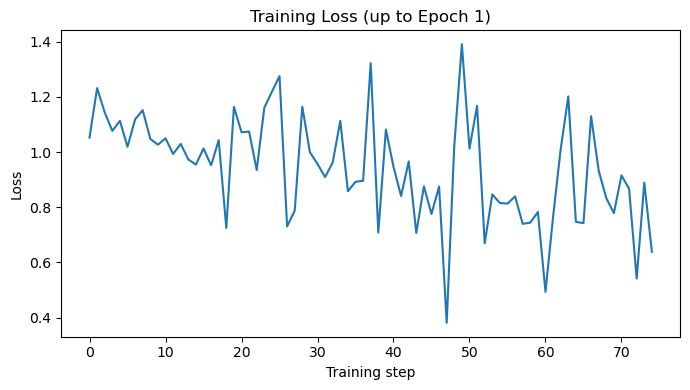

Epoch 1/10, Loss: 0.5556
Epoch 1/10, Loss: 0.9023
Epoch 1/10, Loss: 0.7281
Epoch 1/10, Loss: 0.6673
Epoch 1/10, Loss: 0.7728
Epoch 1/10, Loss: 0.6455
Epoch 1/10, Loss: 0.6043
Epoch 1/10, Loss: 0.2776
Epoch 1/10, Loss: 0.6492
Epoch 1/10, Loss: 0.7784
Epoch 1/10, Loss: 0.7819
Epoch 1/10, Loss: 1.1129
Epoch 1/10, Loss: 1.0501
Epoch 1/10, Loss: 1.0042
Epoch 1/10, Loss: 0.6209
Epoch 1/10, Loss: 0.9306
Epoch 1/10, Loss: 1.4363
Epoch 1/10, Loss: 0.8800
Epoch 1/10, Loss: 0.6773
Epoch 1/10, Loss: 1.0201
Epoch 1/10, Loss: 0.7873
Epoch 1/10, Loss: 0.9437
Epoch 1/10, Loss: 1.1094
Epoch 1/10, Loss: 0.9800
Epoch 1/10, Loss: 0.8839
Epoch 1/10, Loss: 1.1650
Epoch 1/10, Loss: 0.7239
Epoch 1/10, Loss: 0.8334
Epoch 1/10, Loss: 0.9862
Epoch 1/10, Loss: 0.4529
Epoch 1/10, Loss: 0.8548
Epoch 1/10, Loss: 0.7127
Epoch 1/10, Loss: 0.6531
Epoch 1/10, Loss: 0.5308
Epoch 1/10, Loss: 0.9544
Epoch 1/10, Loss: 1.1400
Epoch 1/10, Loss: 0.6954
Epoch 1/10, Loss: 0.4648
Epoch 1/10, Loss: 0.5200
Epoch 1/10, Loss: 0.6247


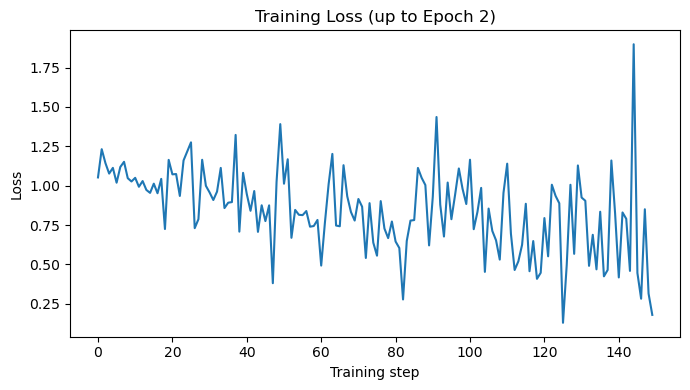

Epoch 2/10, Loss: 0.5227
Epoch 2/10, Loss: 0.9207
Epoch 2/10, Loss: 0.1255
Epoch 2/10, Loss: 0.4722
Epoch 2/10, Loss: 1.1198
Epoch 2/10, Loss: 0.2330
Epoch 2/10, Loss: 0.6866
Epoch 2/10, Loss: 0.6609
Epoch 2/10, Loss: 0.6457
Epoch 2/10, Loss: 0.6828
Epoch 2/10, Loss: 0.7597
Epoch 2/10, Loss: 0.3767
Epoch 2/10, Loss: 0.5679
Epoch 2/10, Loss: 0.1793
Epoch 2/10, Loss: 0.5178
Epoch 2/10, Loss: 1.0003
Epoch 2/10, Loss: 0.6085
Epoch 2/10, Loss: 1.0396
Epoch 2/10, Loss: 0.5516
Epoch 2/10, Loss: 0.7767
Epoch 2/10, Loss: 0.6433
Epoch 2/10, Loss: 0.4888
Epoch 2/10, Loss: 0.8483
Epoch 2/10, Loss: 0.2862
Epoch 2/10, Loss: 0.8357
Epoch 2/10, Loss: 1.1938
Epoch 2/10, Loss: 0.2233
Epoch 2/10, Loss: 0.5298
Epoch 2/10, Loss: 0.5044
Epoch 2/10, Loss: 0.5780
Epoch 2/10, Loss: 0.9581
Epoch 2/10, Loss: 1.3151
Epoch 2/10, Loss: 0.1156
Epoch 2/10, Loss: 0.5114
Epoch 2/10, Loss: 0.8373
Epoch 2/10, Loss: 1.5040
Epoch 2/10, Loss: 0.2668
Epoch 2/10, Loss: 0.9204
Epoch 2/10, Loss: 0.5331
Epoch 2/10, Loss: 0.3792


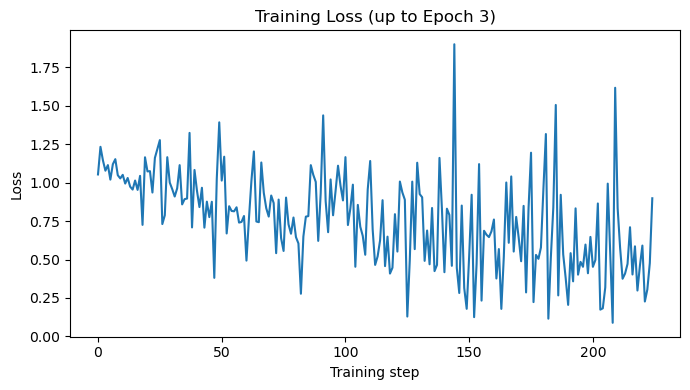

Epoch 3/10, Loss: 0.3881
Epoch 3/10, Loss: 1.8844
Epoch 3/10, Loss: 0.7257
Epoch 3/10, Loss: 0.7627
Epoch 3/10, Loss: 0.5136
Epoch 3/10, Loss: 0.3031
Epoch 3/10, Loss: 0.1853
Epoch 3/10, Loss: 0.3998
Epoch 3/10, Loss: 0.5860
Epoch 3/10, Loss: 0.7680
Epoch 3/10, Loss: 1.0186
Epoch 3/10, Loss: 0.3930
Epoch 3/10, Loss: 0.2651
Epoch 3/10, Loss: 0.2338
Epoch 3/10, Loss: 0.5596
Epoch 3/10, Loss: 0.4716
Epoch 3/10, Loss: 0.4073
Epoch 3/10, Loss: 0.4627
Epoch 3/10, Loss: 0.3509
Epoch 3/10, Loss: 0.2851
Epoch 3/10, Loss: 0.3539
Epoch 3/10, Loss: 0.5434
Epoch 3/10, Loss: 0.6979
Epoch 3/10, Loss: 0.4590
Epoch 3/10, Loss: 0.5301
Epoch 3/10, Loss: 0.7407
Epoch 3/10, Loss: 0.9222
Epoch 3/10, Loss: 0.6028
Epoch 3/10, Loss: 0.5150
Epoch 3/10, Loss: 0.2819
Epoch 3/10, Loss: 0.3430
Epoch 3/10, Loss: 0.6737
Epoch 3/10, Loss: 0.2545
Epoch 3/10, Loss: 0.4475
Epoch 3/10, Loss: 0.3774
Epoch 3/10, Loss: 0.2120
Epoch 3/10, Loss: 0.3505
Epoch 3/10, Loss: 0.0864
Epoch 3/10, Loss: 0.2893
Epoch 3/10, Loss: 0.5344


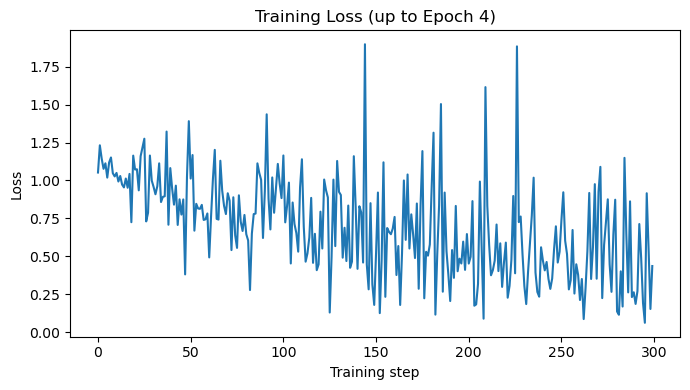

Epoch 4/10, Loss: 0.2705
Epoch 4/10, Loss: 0.1673
Epoch 4/10, Loss: 0.7348
Epoch 4/10, Loss: 0.6559
Epoch 4/10, Loss: 0.5601
Epoch 4/10, Loss: 0.4062
Epoch 4/10, Loss: 0.1808
Epoch 4/10, Loss: 0.9153
Epoch 4/10, Loss: 0.4283
Epoch 4/10, Loss: 0.6383
Epoch 4/10, Loss: 0.2441
Epoch 4/10, Loss: 0.5183
Epoch 4/10, Loss: 0.9833
Epoch 4/10, Loss: 0.4333
Epoch 4/10, Loss: 0.3178
Epoch 4/10, Loss: 0.5128
Epoch 4/10, Loss: 0.4612
Epoch 4/10, Loss: 0.2728
Epoch 4/10, Loss: 0.2478
Epoch 4/10, Loss: 0.8237
Epoch 4/10, Loss: 0.5644
Epoch 4/10, Loss: 0.2164
Epoch 4/10, Loss: 0.6872
Epoch 4/10, Loss: 0.6024
Epoch 4/10, Loss: 0.2219
Epoch 4/10, Loss: 0.6369
Epoch 4/10, Loss: 0.1856
Epoch 4/10, Loss: 0.2425
Epoch 4/10, Loss: 0.1925
Epoch 4/10, Loss: 0.1461
Epoch 4/10, Loss: 0.4341
Epoch 4/10, Loss: 0.6627
Epoch 4/10, Loss: 0.1424
Epoch 4/10, Loss: 0.2666
Epoch 4/10, Loss: 0.1145
Epoch 4/10, Loss: 0.3578
Epoch 4/10, Loss: 0.5631
Epoch 4/10, Loss: 0.8344
Epoch 4/10, Loss: 0.3837
Epoch 4/10, Loss: 0.3125


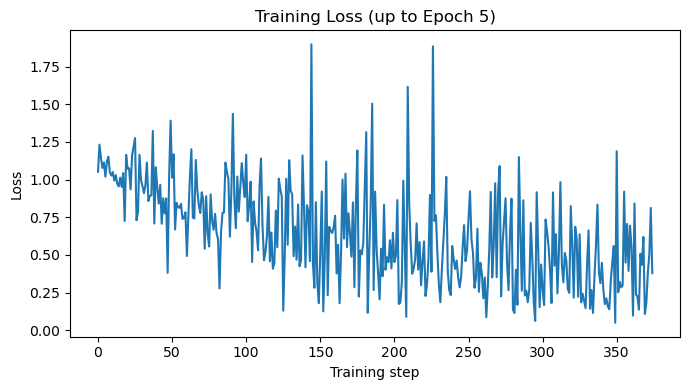

Epoch 5/10, Loss: 0.0794
Epoch 5/10, Loss: 0.4326
Epoch 5/10, Loss: 0.1802
Epoch 5/10, Loss: 0.3914
Epoch 5/10, Loss: 0.1519
Epoch 5/10, Loss: 0.1115
Epoch 5/10, Loss: 0.0520
Epoch 5/10, Loss: 0.3894
Epoch 5/10, Loss: 0.9813
Epoch 5/10, Loss: 0.5045
Epoch 5/10, Loss: 0.3833
Epoch 5/10, Loss: 0.2042
Epoch 5/10, Loss: 0.2518
Epoch 5/10, Loss: 0.3407
Epoch 5/10, Loss: 0.4353
Epoch 5/10, Loss: 0.5286
Epoch 5/10, Loss: 0.4919
Epoch 5/10, Loss: 0.1407
Epoch 5/10, Loss: 0.4350
Epoch 5/10, Loss: 0.7126
Epoch 5/10, Loss: 0.7674
Epoch 5/10, Loss: 0.3117
Epoch 5/10, Loss: 0.3749
Epoch 5/10, Loss: 0.2847
Epoch 5/10, Loss: 0.4378
Epoch 5/10, Loss: 0.1455
Epoch 5/10, Loss: 0.1462
Epoch 5/10, Loss: 0.2230
Epoch 5/10, Loss: 0.5372
Epoch 5/10, Loss: 0.1377
Epoch 5/10, Loss: 0.1573
Epoch 5/10, Loss: 0.8738
Epoch 5/10, Loss: 0.2249
Epoch 5/10, Loss: 0.4019
Epoch 5/10, Loss: 0.2000
Epoch 5/10, Loss: 0.2133
Epoch 5/10, Loss: 0.1973
Epoch 5/10, Loss: 0.1097
Epoch 5/10, Loss: 0.1382
Epoch 5/10, Loss: 0.5186


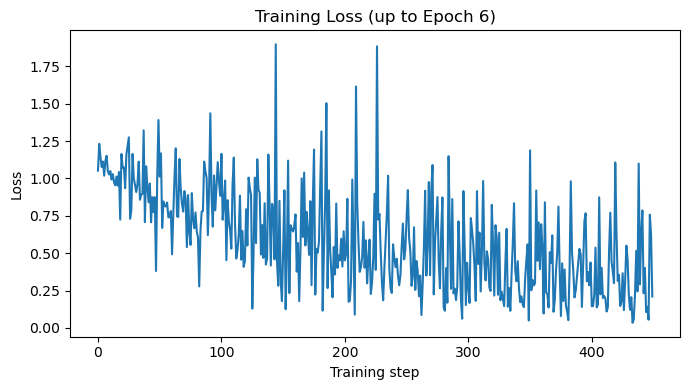

Epoch 6/10, Loss: 0.3438
Epoch 6/10, Loss: 0.0777
Epoch 6/10, Loss: 0.8153
Epoch 6/10, Loss: 0.2583
Epoch 6/10, Loss: 0.3073
Epoch 6/10, Loss: 0.2105
Epoch 6/10, Loss: 0.1194
Epoch 6/10, Loss: 0.1976
Epoch 6/10, Loss: 0.2504
Epoch 6/10, Loss: 0.5997
Epoch 6/10, Loss: 0.1786
Epoch 6/10, Loss: 0.0861
Epoch 6/10, Loss: 0.1103
Epoch 6/10, Loss: 0.2240
Epoch 6/10, Loss: 0.1471
Epoch 6/10, Loss: 0.8916
Epoch 6/10, Loss: 0.0956
Epoch 6/10, Loss: 1.0487
Epoch 6/10, Loss: 0.2491
Epoch 6/10, Loss: 0.2896
Epoch 6/10, Loss: 0.7691
Epoch 6/10, Loss: 0.2473
Epoch 6/10, Loss: 0.6364
Epoch 6/10, Loss: 0.3242
Epoch 6/10, Loss: 0.0374
Epoch 6/10, Loss: 0.7002
Epoch 6/10, Loss: 0.9669
Epoch 6/10, Loss: 0.5731
Epoch 6/10, Loss: 0.0626
Epoch 6/10, Loss: 0.8624
Epoch 6/10, Loss: 1.0986
Epoch 6/10, Loss: 0.3664
Epoch 6/10, Loss: 0.3215
Epoch 6/10, Loss: 0.0527
Epoch 6/10, Loss: 0.1493
Epoch 6/10, Loss: 0.0563
Epoch 6/10, Loss: 0.0914
Epoch 6/10, Loss: 0.1880
Epoch 6/10, Loss: 0.1745
Epoch 6/10, Loss: 0.0649


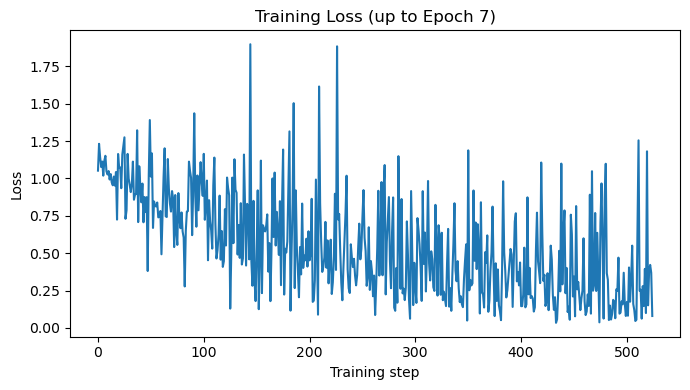

Epoch 7/10, Loss: 0.1233
Epoch 7/10, Loss: 0.0983
Epoch 7/10, Loss: 0.6230
Epoch 7/10, Loss: 0.1880
Epoch 7/10, Loss: 0.4377
Epoch 7/10, Loss: 0.1909
Epoch 7/10, Loss: 0.2762
Epoch 7/10, Loss: 0.1855
Epoch 7/10, Loss: 0.2456
Epoch 7/10, Loss: 0.0897
Epoch 7/10, Loss: 0.3484
Epoch 7/10, Loss: 0.0769
Epoch 7/10, Loss: 0.2217
Epoch 7/10, Loss: 0.1822
Epoch 7/10, Loss: 0.2059
Epoch 7/10, Loss: 0.0639
Epoch 7/10, Loss: 0.1723
Epoch 7/10, Loss: 0.0631
Epoch 7/10, Loss: 1.0280
Epoch 7/10, Loss: 0.2305
Epoch 7/10, Loss: 0.4466
Epoch 7/10, Loss: 0.3597
Epoch 7/10, Loss: 0.5315
Epoch 7/10, Loss: 0.2604
Epoch 7/10, Loss: 0.2115
Epoch 7/10, Loss: 0.1088
Epoch 7/10, Loss: 0.1721
Epoch 7/10, Loss: 0.0561
Epoch 7/10, Loss: 0.4510
Epoch 7/10, Loss: 0.6615
Epoch 7/10, Loss: 0.6687
Epoch 7/10, Loss: 0.4154
Epoch 7/10, Loss: 0.1745
Epoch 7/10, Loss: 0.0651
Epoch 7/10, Loss: 0.2770
Epoch 7/10, Loss: 0.0946
Epoch 7/10, Loss: 1.0086
Epoch 7/10, Loss: 0.1343
Epoch 7/10, Loss: 0.2630
Epoch 7/10, Loss: 1.1554


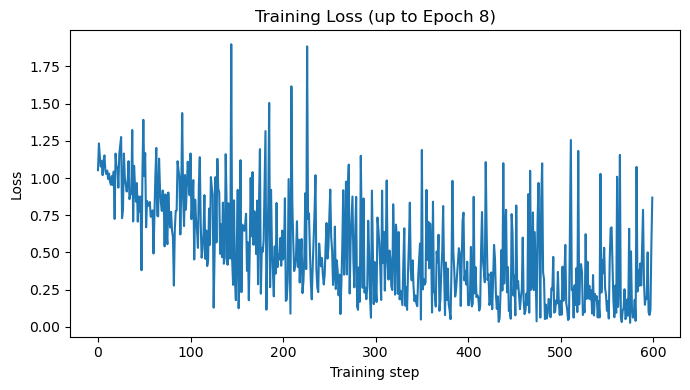

Epoch 8/10, Loss: 0.1922
Epoch 8/10, Loss: 0.1355
Epoch 8/10, Loss: 0.2445
Epoch 8/10, Loss: 0.1441
Epoch 8/10, Loss: 0.0650
Epoch 8/10, Loss: 0.3487
Epoch 8/10, Loss: 0.0910
Epoch 8/10, Loss: 0.1771
Epoch 8/10, Loss: 0.2179
Epoch 8/10, Loss: 0.1865
Epoch 8/10, Loss: 0.3056
Epoch 8/10, Loss: 0.2576
Epoch 8/10, Loss: 0.3724
Epoch 8/10, Loss: 0.0205
Epoch 8/10, Loss: 0.2306
Epoch 8/10, Loss: 0.1226
Epoch 8/10, Loss: 0.0648
Epoch 8/10, Loss: 0.1987
Epoch 8/10, Loss: 0.2960
Epoch 8/10, Loss: 0.0563
Epoch 8/10, Loss: 0.0398
Epoch 8/10, Loss: 0.5994
Epoch 8/10, Loss: 0.1115
Epoch 8/10, Loss: 0.1001
Epoch 8/10, Loss: 0.5114
Epoch 8/10, Loss: 0.1913
Epoch 8/10, Loss: 0.1128
Epoch 8/10, Loss: 0.0766
Epoch 8/10, Loss: 0.1490
Epoch 8/10, Loss: 0.0119
Epoch 8/10, Loss: 0.5123
Epoch 8/10, Loss: 0.1825
Epoch 8/10, Loss: 0.2740
Epoch 8/10, Loss: 0.8197
Epoch 8/10, Loss: 0.0408
Epoch 8/10, Loss: 0.4226
Epoch 8/10, Loss: 0.1709
Epoch 8/10, Loss: 0.0732
Epoch 8/10, Loss: 0.0300
Epoch 8/10, Loss: 0.1795


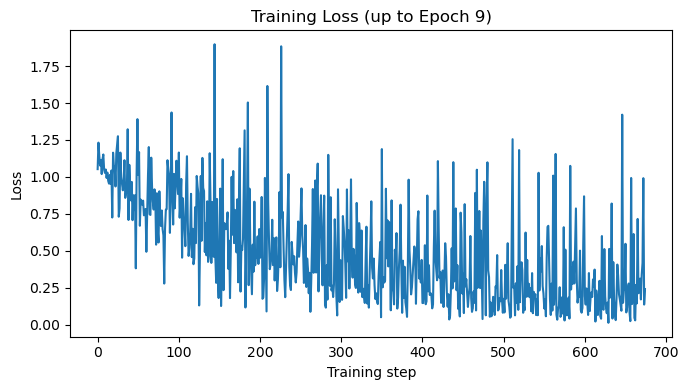

Epoch 9/10, Loss: 0.2168
Epoch 9/10, Loss: 0.2605
Epoch 9/10, Loss: 0.1189
Epoch 9/10, Loss: 0.0572
Epoch 9/10, Loss: 0.8679
Epoch 9/10, Loss: 0.3475
Epoch 9/10, Loss: 0.4537
Epoch 9/10, Loss: 0.0285
Epoch 9/10, Loss: 0.1941
Epoch 9/10, Loss: 0.2948
Epoch 9/10, Loss: 0.0294
Epoch 9/10, Loss: 0.7648
Epoch 9/10, Loss: 0.8480
Epoch 9/10, Loss: 0.0227
Epoch 9/10, Loss: 0.1096
Epoch 9/10, Loss: 0.0184
Epoch 9/10, Loss: 0.1075
Epoch 9/10, Loss: 0.5465
Epoch 9/10, Loss: 0.0287
Epoch 9/10, Loss: 0.3008
Epoch 9/10, Loss: 0.4250
Epoch 9/10, Loss: 0.0860
Epoch 9/10, Loss: 0.2436
Epoch 9/10, Loss: 0.2905
Epoch 9/10, Loss: 0.6082
Epoch 9/10, Loss: 0.2241
Epoch 9/10, Loss: 0.2203
Epoch 9/10, Loss: 0.0802
Epoch 9/10, Loss: 0.7478
Epoch 9/10, Loss: 0.0656
Epoch 9/10, Loss: 0.3009
Epoch 9/10, Loss: 0.2309
Epoch 9/10, Loss: 0.1000
Epoch 9/10, Loss: 0.3311
Epoch 9/10, Loss: 0.2018
Epoch 9/10, Loss: 0.1596
Epoch 9/10, Loss: 0.1235
Epoch 9/10, Loss: 0.1277
Epoch 9/10, Loss: 0.0494
Epoch 9/10, Loss: 0.1272


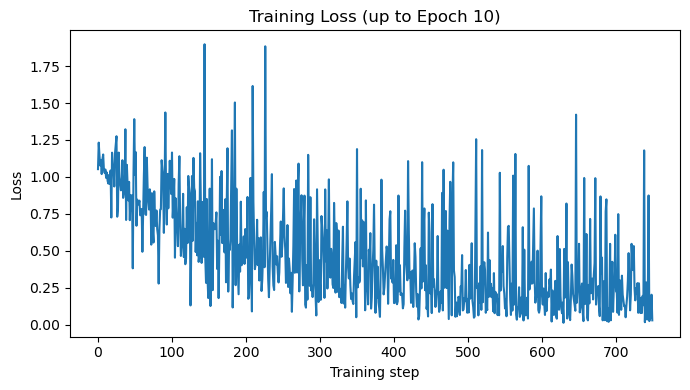

In [6]:
m = model
loss = nn.NLLLoss()

optimiser = torch.optim.Adam(m.parameters(), lr=0.0001)

NUM_EPOCHS = 10
losses = []
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimiser.zero_grad()

        y_pred = m(inputs.to(device))
        loss_v = loss(y_pred, labels.to(device))

        loss_v.backward()
        losses.append(loss_v.item())

        optimiser.step()
    
        print(f'Epoch {epoch}/{NUM_EPOCHS}, Loss: {loss_v.item():.4f}')
    # Plot after each epoch, only the completed part
    plt.figure(figsize=(7, 4))
    sns.lineplot(x=range(len(losses)), y=losses)
    plt.title(f'Training Loss (up to Epoch {epoch+1})')
    plt.xlabel('Training step')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()    



In [7]:



y_test = []
y_test_hat = []

for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        outputs = model(inputs.to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    y_test.extend(y_test_temp.cpu().numpy())
    y_test_hat.extend(preds)

acc = accuracy_score(y_test, y_test_hat)
print(f'Accuracy: {acc*100:.2f} %')
cm = confusion_matrix(y_test, y_test_hat)
cm



Accuracy: 91.67 %


array([[16,  0,  4],
       [ 0, 20,  0],
       [ 0,  1, 19]])